# Study 2023 Canadian Wildfires using TROPESS CrIS JPSS-1 Carbon Monoxide (CO) data products

This code reads TROPESS CrIS JPSS-1 CO data products for June 2023 and June 2022 and make a monthly average data product and plot and compare them.


In [1]:
import datetime
import contextlib

from pathlib import Path

import pandas as pd

import numpy as np
from netCDF4 import Dataset

import matplotlib.pyplot as plt

import imageio.v2 as imageio

from mpl_toolkits.basemap import Basemap

from scipy.interpolate import griddata
from scipy.spatial import cKDTree


Let's read June 2023 daily data products and make a time series and make a monthly average of XCO (colum CO). 
The datasets should be already downloaded in the local directory ./data. 
Please refer to the tutorial about how to download TROPESS datasets from GES DISC.  

In [2]:
# Specify date range
start_date = datetime.date(2023, 6, 1)
end_date = datetime.date(2023, 6, 30)

x_col_time_series_2023_june = []

# Loop through the date range and plot Carbon Monoxide for each day
for current_date in pd.date_range(start_date, end_date):
    # Open the netCDF file
    file_date = current_date.strftime("%Y%m%d")
    dataset = Dataset(f'./data/TROPESS_CrIS-JPSS1_L2_Summary_CO_{file_date}_MUSES_R1p20_FS_F0p6.nc', 'r')
    print("reading data from =", file_date)
    
    # Read the data from your variables
    latitude = dataset.variables['latitude'][:]
    longitude = dataset.variables['longitude'][:]
    x_col = dataset.variables['x_col'][:]

    dataset.close()

    # Filter the data for latitude 60S to 80N
    latitude_max = 80.0
    latitude_min = -60.0
    longitude_max = 180.0
    longitude_min = -180.0

    selection_only = np.where(
        (latitude > latitude_min) & (latitude < latitude_max) & 
        (longitude > longitude_min) &(longitude < longitude_max)
    )[0]

    latitude = latitude[selection_only]
    longitude = longitude[selection_only]
    x_col = x_col[selection_only]

    pixel_size_deg = 1.0 # 1 degree resolution

    # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[-60:81:pixel_size_deg, -180:181:pixel_size_deg]

    # Interpolate the data using griddata
    grid_x_col = griddata((latitude, longitude), x_col, (grid_lat, grid_lon), method='linear', rescale=True)

    # Find the distance to the nearest original point for each point in the interpolated grid
    tree = cKDTree(np.vstack((latitude, longitude)).T)
    dist, _ = tree.query(np.vstack((grid_lat.ravel(), grid_lon.ravel())).T)

    # Reshape the distance array to have the same shape as the x_col grid
    dist_grid = dist.reshape(grid_x_col.shape)

    # Mask the interpolated values that are too far from any original point
    max_distance_degrees = 3.0
    grid_x_col[dist_grid > max_distance_degrees] = np.nan
    
    # Make the time series of daily x_col for one month by appending each day's dataset. 
    x_col_time_series_2023_june.append(grid_x_col)

x_col_time_series_2023_june = np.array(x_col_time_series_2023_june)    
print(x_col_time_series_2023_june.shape)
x_col_month_mean_2023 = np.mean(x_col_time_series_2023_june, axis=0)

reading data from = 20230601
reading data from = 20230602
reading data from = 20230603
reading data from = 20230604
reading data from = 20230605
reading data from = 20230606
reading data from = 20230607
reading data from = 20230608
reading data from = 20230609
reading data from = 20230610
reading data from = 20230611
reading data from = 20230612
reading data from = 20230613
reading data from = 20230614
reading data from = 20230615
reading data from = 20230616
reading data from = 20230617
reading data from = 20230618
reading data from = 20230619
reading data from = 20230620
reading data from = 20230621
reading data from = 20230622
reading data from = 20230623
reading data from = 20230624
reading data from = 20230625
reading data from = 20230626
reading data from = 20230627
reading data from = 20230628
reading data from = 20230629
reading data from = 20230630
(30, 141, 361)


Let's make a global map of the June 2023 averaged XCO using Basemap. 

/var/folders/zr/c_5x9wyd64q_7n4y7t0497g1z1j8qn/T/ipykernel_63477/3439567774.py:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  sc = m.pcolormesh(grid_lon, grid_lat, x_col_month_mean_2023, latlon=True, cmap='jet', alpha=0.7, vmin=60.0, vmax=200.0)


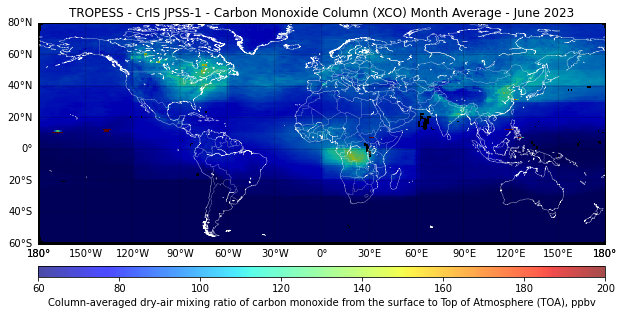

In [3]:
    # Calculate width and height
    aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
    w = 3600; h = w / aspect_ratio

    # Specify figure size (in inches)
    dpi = 300; 
    plt.figure(figsize=(w / dpi, h / dpi))  

    # Create a basemap instance
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-60, urcrnrlat=80,  # set latitude limits to -80 and 80
                llcrnrlon=-180, urcrnrlon=180)  # set longitude limits to -180 and -180

    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    #m.drawstates(linewidth=0.2, color='white')


    # Draw parallels (latitude lines) and meridians (longitude lines)
    parallels = np.arange(-60., 81., 20.)
    m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

    meridians = np.arange(-180., 181., 30.)
    m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)
    
    pixel_size_deg = 1.0 # 1 degree resolution

    # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[-60:81:pixel_size_deg, -180:181:pixel_size_deg]

    
    # Plot the interpolated data using pcolormesh instead of scatter
    sc = m.pcolormesh(grid_lon, grid_lat, x_col_month_mean_2023, latlon=True, cmap='jet', alpha=0.7, vmin=60.0, vmax=200.0)
    
    
    # Add a colorbar
    cbar = m.colorbar(sc, location='bottom', pad="10%")
    cbar.set_label('Column-averaged dry-air mixing ratio of carbon monoxide from the surface to Top of Atmosphere (TOA), ppbv')

    # set plot title
    title_date = current_date.strftime("%b-%Y")
    title_min = np.nanmin(x_col_month_mean_2023)
    title_max = np.nanmax(x_col_month_mean_2023)
    plt.title(f'TROPESS - CrIS JPSS-1 - Carbon Monoxide Column (XCO) Month Average - June 2023')
    #\nMin: {title_min:.01f}, Max: {title_max:.01f} ppbv')

    # Save figure to PNG file
    plt.savefig(f'./images_average/TROPESS_Canadian-Fires_CrIS-JPSS-1_XCO_June_2023_month_average.png', dpi=dpi, bbox_inches='tight')

    plt.show()
    plt.close()


Let's read June 2022 daily data products and make a time series and make a monthly average of XCO (colum CO). 
The datasets should be already downloaded in the local directory ./data. 
Please refer to the tutorial about how to download TROPESS datasets from GES DISC.  

In [4]:
# Specify date range
start_date = datetime.date(2022, 6, 1)
end_date = datetime.date(2022, 6, 30)

x_col_time_series_2022_june = []

# Loop through the date range and plot Carbon Monoxide for each day
for current_date in pd.date_range(start_date, end_date):
    # Open the netCDF file
    file_date = current_date.strftime("%Y%m%d")
    dataset = Dataset(f'./data/TROPESS_CrIS-JPSS1_L2_Summary_CO_{file_date}_MUSES_R1p17_FS_F0p6.nc', 'r')
    print("reading data from =", file_date)
    
    # Read the data from your variables
    latitude = dataset.variables['latitude'][:]
    longitude = dataset.variables['longitude'][:]
    x_col = dataset.variables['x_col'][:]

    dataset.close()

    # Filter the data for latitude 80S to 80N
    latitude_max = 80.0
    latitude_min = -60.0
    longitude_max = 180.0
    longitude_min = -180.0

    selection_only = np.where(
        (latitude > latitude_min) & (latitude < latitude_max) & 
        (longitude > longitude_min) &(longitude < longitude_max)
    )[0]

    latitude = latitude[selection_only]
    longitude = longitude[selection_only]
    x_col = x_col[selection_only]


    pixel_size_deg = 1.0 # 1 degree resolution

    # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[-60:81:pixel_size_deg, -180:181:pixel_size_deg]

    # Interpolate the data using griddata
    grid_x_col = griddata((latitude, longitude), x_col, (grid_lat, grid_lon), method='linear', rescale=True)

    # Find the distance to the nearest original point for each point in the interpolated grid
    tree = cKDTree(np.vstack((latitude, longitude)).T)
    dist, _ = tree.query(np.vstack((grid_lat.ravel(), grid_lon.ravel())).T)

    # Reshape the distance array to have the same shape as the x_col grid
    dist_grid = dist.reshape(grid_x_col.shape)

    # Mask the interpolated values that are too far from any original point
    max_distance_degrees = 3.0
    grid_x_col[dist_grid > max_distance_degrees] = np.nan
    
    x_col_time_series_2022_june.append(grid_x_col)
    

x_col_time_series_2022_june = np.array(x_col_time_series_2022_june)    
print(x_col_time_series_2022_june.shape)
x_col_month_mean_2022 = np.mean(x_col_time_series_2022_june, axis=0)
print("X_col_month_mean_shape = ", x_col_month_mean_2022.shape)

reading data from = 20220601
reading data from = 20220602
reading data from = 20220603
reading data from = 20220604
reading data from = 20220605
reading data from = 20220606
reading data from = 20220607
reading data from = 20220608
reading data from = 20220609
reading data from = 20220610
reading data from = 20220611
reading data from = 20220612
reading data from = 20220613
reading data from = 20220614
reading data from = 20220615
reading data from = 20220616
reading data from = 20220617
reading data from = 20220618
reading data from = 20220619
reading data from = 20220620
reading data from = 20220621
reading data from = 20220622
reading data from = 20220623
reading data from = 20220624
reading data from = 20220625
reading data from = 20220626
reading data from = 20220627
reading data from = 20220628
reading data from = 20220629
reading data from = 20220630
(30, 141, 361)
X_col_month_mean_shape =  (141, 361)


Let's make a global map of the June 2022 averaged XCO using Basemap. 

/var/folders/zr/c_5x9wyd64q_7n4y7t0497g1z1j8qn/T/ipykernel_63477/3856721022.py:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  sc = m.pcolormesh(grid_lon, grid_lat, x_col_month_mean_2022, latlon=True, cmap='jet', alpha=0.7, vmin=60.0, vmax=200.0)


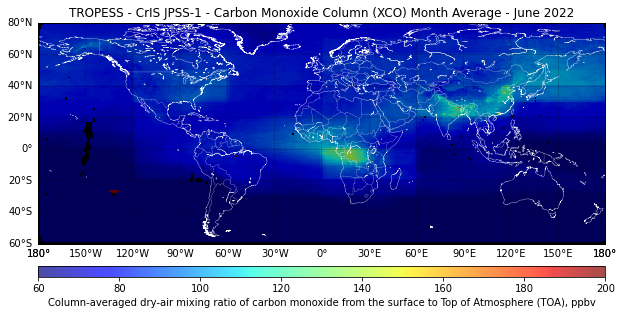

In [5]:
    # Calculate width and height
    aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
    w = 3600; h = w / aspect_ratio

    # Specify figure size (in inches)
    dpi = 300; 
    plt.figure(figsize=(w / dpi, h / dpi))  

    # Create a basemap instance
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-60, urcrnrlat=80,  # set latitude limits to -80 and 80
                llcrnrlon=-180, urcrnrlon=180)  # set longitude limits to -180 and -180

    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    #m.drawstates(linewidth=0.2, color='white')


    # Draw parallels (latitude lines) and meridians (longitude lines)
    parallels = np.arange(-60., 81., 20.)
    m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

    meridians = np.arange(-180., 181., 30.)
    m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)
    
    pixel_size_deg = 1.0 # 1 degree resolution

    # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[-60:81:pixel_size_deg, -180:181:pixel_size_deg]

    
    # Plot the interpolated data using pcolormesh instead of scatter
    sc = m.pcolormesh(grid_lon, grid_lat, x_col_month_mean_2022, latlon=True, cmap='jet', alpha=0.7, vmin=60.0, vmax=200.0)

    
    # Add a colorbar
    cbar = m.colorbar(sc, location='bottom', pad="10%")
    cbar.set_label('Column-averaged dry-air mixing ratio of carbon monoxide from the surface to Top of Atmosphere (TOA), ppbv')

    # set plot title
    title_date = current_date.strftime("%b-%Y")
    title_min = np.nanmin(x_col_month_mean_2022)
    title_max = np.nanmax(x_col_month_mean_2022)
    plt.title(f'TROPESS - CrIS JPSS-1 - Carbon Monoxide Column (XCO) Month Average - June 2022')
    #\nMin: {title_min:.01f}, Max: {title_max:.01f} ppbv')

    # Save figure to PNG file
    plt.savefig(f'./images_average/TROPESS_Canadian-Fires_CrIS-JPSS-1_XCO_June_2022_month_average.png', dpi=dpi, bbox_inches='tight')

    plt.show()
    plt.close()


Let's get the difference between June 2023 XCO and June 2022 XCO and plot the difference in a global map. 

/var/folders/zr/c_5x9wyd64q_7n4y7t0497g1z1j8qn/T/ipykernel_63477/3357831191.py:37: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  sc = m.pcolormesh(grid_lon, grid_lat, x_col_diff_month_average, latlon=True, cmap='seismic', alpha=0.8, vmin=-60, vmax=60.0)


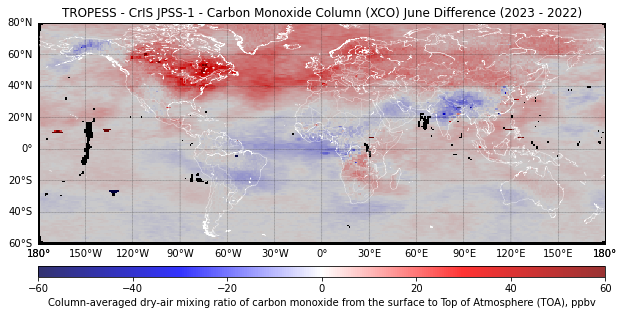

In [6]:
    x_col_diff_month_average = x_col_month_mean_2023 - x_col_month_mean_2022
    #print (x_col_diff_month_average.shape)
 
    # Calculate width and height
    aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
    w = 3600; h = w / aspect_ratio

    # Specify figure size (in inches)
    dpi = 300; 
    plt.figure(figsize=(w / dpi, h / dpi))  

    # Create a basemap instance
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-60, urcrnrlat=80,  # set latitude limits to -80 and 80
                llcrnrlon=-180, urcrnrlon=180)  # set longitude limits to -180 and -180

    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    #m.drawstates(linewidth=0.2, color='white')


    # Draw parallels (latitude lines) and meridians (longitude lines)
    parallels = np.arange(-60., 81., 20.)
    m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

    meridians = np.arange(-180., 181., 30.)
    m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)
    
    pixel_size_deg = 1.0 # 1 degree resolution

    # Get the grid for the map
    grid_lat, grid_lon = np.mgrid[-60:81:pixel_size_deg, -180:181:pixel_size_deg]

    
    # Plot the difference data using pcolormesh instead of scatter
    sc = m.pcolormesh(grid_lon, grid_lat, x_col_diff_month_average, latlon=True, cmap='seismic', alpha=0.8, vmin=-60, vmax=60.0)

    # Add a colorbar
    cbar = m.colorbar(sc, location='bottom', pad="10%")
    cbar.set_label('Column-averaged dry-air mixing ratio of carbon monoxide from the surface to Top of Atmosphere (TOA), ppbv')

    # set plot title
    #title_date = current_date.strftime("%b-%Y")
    title_min = np.nanmin(x_col_diff_month_average)
    title_max = np.nanmax(x_col_diff_month_average)
    plt.title(f'TROPESS - CrIS JPSS-1 - Carbon Monoxide Column (XCO) June Difference (2023 - 2022)')
    #' \nMin: {title_min:.01f}, Max: {title_max:.01f} ppbv')

    # Save figure to PNG file
    plt.savefig(f'./images_average/TROPESS_Canadian-Fires_CrIS-JPSS-1_XCO_2023_2022_June_month_diff.png', dpi=dpi, bbox_inches='tight')

    plt.show()
    plt.close()


Let's calculate the average difference of xco in the Northeast part of North America (latitude = [40,60] and longitude [-90,-60]].)

In [7]:
    latitude_min=40
    latitude_max=60
    longitude_min=-90
    longitude_max=-60
    
    small_selection = np.where(
        (grid_lat > latitude_min) & (grid_lat < latitude_max) & 
        (grid_lon > longitude_min) &(grid_lon < longitude_max)
    )

    #print (small_selection)
    grid_lat_small = grid_lat[small_selection]
    grid_lon_small = grid_lon[small_selection]
    x_col_diff_small = x_col_diff_month_average[small_selection]
    
    
    x_col_diff_mean = x_col_diff_small.mean()
    print("Northeast America XCO increase from 2022 June to 2023 June = ", "{0:.2f}".format(x_col_diff_mean), 'ppbv')
    

Northeast America XCO increase from 2022 June to 2023 June =  20.44 ppbv


Let's write the monthly average data and difference data in a NetCDF file for future use. 

In [8]:
import numpy as np
import datetime
from netCDF4 import Dataset,num2date,date2num


longitude_1D = np.arange(-180,181,1.0)
latitude_1D = np.arange(-60,81,1.0)

#print('length of latitude =', len(latitude_1D))
#print('length of longitude =', len(longitude_1D))

ncout = Dataset('TROPESS_CRIS_JPSS1_2022_2023_June_XCO.nc', mode='w', format='NETCDF4_CLASSIC')

ncout.createDimension('latitude', len(latitude_1D))
ncout.createDimension('longitude', len(longitude_1D))

lonvar = ncout.createVariable('longitude','float32',('longitude'))
lonvar[:] = longitude_1D

latvar = ncout.createVariable('latitude','float32',('latitude'))
latvar[:] = latitude_1D

myvar = ncout.createVariable('xco_2022_June','float32',('latitude','longitude'))
myvar.setncattr('units','ppbv')
myvar[:] = x_col_month_mean_2022;

myvar = ncout.createVariable('xco_2023_June','float32',('latitude','longitude'))
myvar.setncattr('units','ppbv')
myvar[:] = x_col_month_mean_2023;

myvar = ncout.createVariable('xco_diff','float32',('latitude','longitude'))
myvar.setncattr('units','ppbv')
myvar[:] = x_col_diff_month_average;
ncout.close();


